In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MultiLabelBinarizer

import pathlib

2023-10-09 14:04:30.778859: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import the dataset

batch_size = 32
img_height = 180
img_width = 180

train_df = pd.read_csv("./datasets/training/metadata.csv")
eval_df = pd.read_csv("./datasets/evaluation/metadata.csv")

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory="./datasets/training/",
    labels=train_df['Disease_Risk'].to_list(),
    label_mode="int",
    
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory="./datasets/evaluation/",
    labels=eval_df['Disease_Risk'].to_list(),
    label_mode="int",
    image_size=(img_height, img_width), 
    batch_size=batch_size,
)

Found 1920 files belonging to 2 classes.
Found 640 files belonging to 2 classes.


In [3]:
class_names = train_ds.class_names
print(class_names)

[0, 1]


2023-10-09 14:04:50.474461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1920]
	 [[{{node Placeholder/_0}}]]
2023-10-09 14:04:50.474906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1920]
	 [[{{node Placeholder/_0}}]]


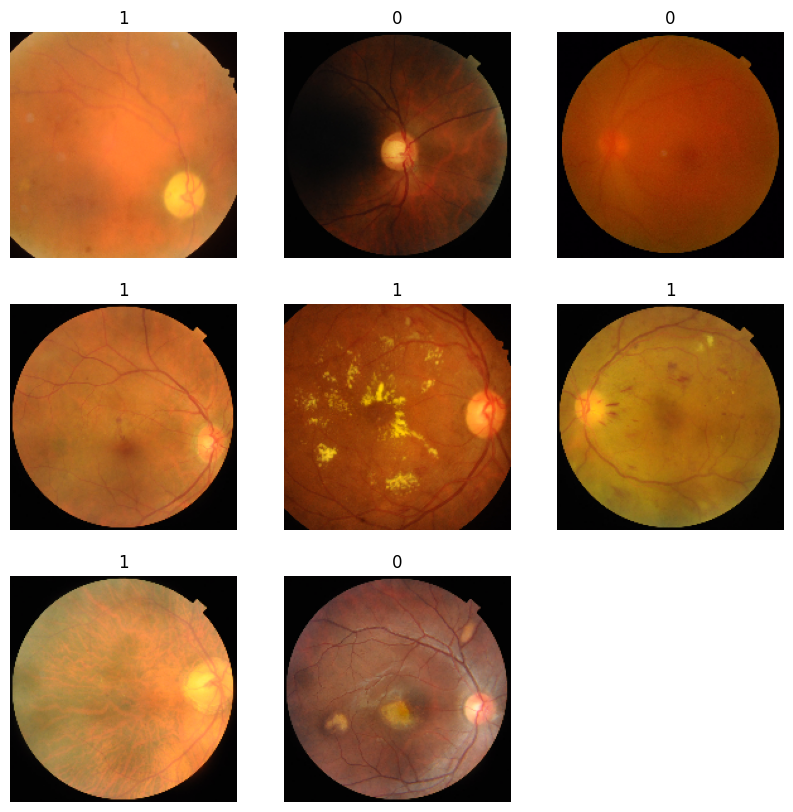

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [19]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)
])

In [20]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-10-07 20:42:48.550042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1920]
	 [[{{node Placeholder/_4}}]]
2023-10-07 20:42:48.550603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1920]
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - ETA: 0s - loss: 0.5311 - accuracy: 0.7786

2023-10-07 20:44:02.352736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [640]
	 [[{{node Placeholder/_4}}]]
2023-10-07 20:44:02.353364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [640]
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 93s 704ms/step - loss: 0.5311 - accuracy: 0.7786 - val_loss: 0.5412 - val_accuracy: 0.7906
Epoch 2/10
60/60 [==============================] - 91s 639ms/step - loss: 0.5182 - accuracy: 0.7911 - val_loss: 0.5541 - val_accuracy: 0.7906
Epoch 3/10
60/60 [==============================] - 90s 661ms/step - loss: 0.5048 - accuracy: 0.7911 - val_loss: 0.5771 - val_accuracy: 0.7906
Epoch 4/10
60/60 [==============================] - 89s 646ms/step - loss: 0.5095 - accuracy: 0.7906 - val_loss: 0.5345 - val_accuracy: 0.7906
Epoch 5/10
60/60 [==============================] - 89s 654ms/step - loss: 0.5067 - accuracy: 0.7911 - val_loss: 0.6089 - val_accuracy: 0.7906
Epoch 6/10
60/60 [==============================] - 88s 634ms/step - loss: 0.5066 - accuracy: 0.7911 - val_loss: 0.5446 - val_accuracy: 0.7906
Epoch 7/10
60/60 [==============================] - 90s 649ms/step - loss: 0.5037 - accuracy: 0.7911 - val_loss: 0.5526 - val_accuracy: 0.7906
Epoch 8/10

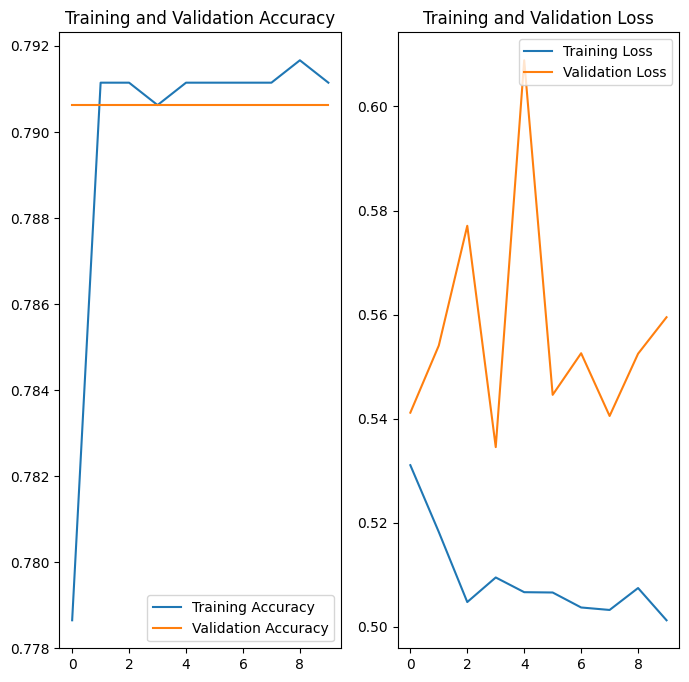

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Save the model

model.save('model.nul')

INFO:tensorflow:Assets written to: model.nul/assets


INFO:tensorflow:Assets written to: model.nul/assets
